1. Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.<br>
Perform following tasks:<br> 1. Pre-process the dataset.<br> 2. Identify outliers. <br>3. Check the correlation.<br> 4. Implement linear regression and random forest regression models. <br>5. Evaluate the models and compare their respective scores like R2, RMSE, etc.<br>
Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df  = pd.read_csv('data/uber.csv')
if ~df.empty:
    print("Loaded!")

Loaded!


In [3]:
print(df.columns)
print(f"\nDataset has {df.shape[0]} rows and {df.shape[1]} columns")
df.head(5)

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

Dataset has 200000 rows and 9 columns


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


## Preprocessing dataset

1. dropping reduandant features
2. handling NA values
3. feature construction - datetime,distance
4. remove duplicates
5. converting categorical to quantitative
6. Identifying and handling outliers


In [5]:
df.drop(columns = ["Unnamed: 0",'key'],inplace=True)

In [6]:
pd.DataFrame(df.isnull().sum().sort_values(),columns = ["Total null values"])

,Total null values
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
passenger_count,0
dropoff_longitude,1
dropoff_latitude,1


In [7]:
df.dropna(inplace=True)
pd.DataFrame(df.isnull().sum().sort_values(),columns = ["Total null values"])

,Total null values
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


### latitute and longitude
The numbers are in decimal degrees format and range from -90 to 90 for latitude and -180 to 180 for longitude.

In [8]:
df = df[
    (df.pickup_latitude  > -90) & (df.pickup_latitude  < 90) &
    (df.dropoff_latitude > -90) & (df.dropoff_latitude < 90) &
    
    (df.pickup_longitude  > -180) & (df.pickup_longitude  < 180) &
    (df.dropoff_longitude > -180) & (df.dropoff_longitude < 180)]

### Feature Construction

In [9]:
df.pickup_datetime = pd.to_datetime(df['pickup_datetime'],infer_datetime_format=True)

df['year'] = df.pickup_datetime.dt.year
df['weekday'] = df.pickup_datetime.dt.weekday
df['month'] = df.pickup_datetime.dt.month

df.head(3)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,month
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,5
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,7
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,8


In [10]:
# !pip install geopy

In [11]:
import geopy.distance

distance = []

for i in df.index:
    dist = geopy.distance.distance((df.pickup_latitude[i],df.pickup_longitude[i]),(df.dropoff_latitude[i],df.dropoff_longitude[i])).m
    distance.append(round(dist,2))
    
df['distance'] = distance
df.head(3)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,month,distance
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,5,1681.11
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,7,2454.36
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,8,5039.60


In [12]:
df.drop(columns = ['pickup_datetime','month'],axis = 1,inplace=True)

In [13]:
df.head(3)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,5039.60


### Removing duplicates

In [14]:
old_rows = df.shape[0]
df.drop_duplicates(inplace=True)
new_rows = df.shape[0]

print(f"{old_rows - new_rows} duplicated rows found and dropped!")

1183 duplicated rows found and dropped!


In [15]:
original_df =  df.copy(deep=True) #dont run this again

In [16]:
# df = original_df
# print(df.shape)

### Categorical  to Quantitative values

In [17]:
features = df.nunique().sort_values()
features

year                      7
weekday                   7
passenger_count           8
fare_amount            1244
pickup_longitude      71055
dropoff_longitude     76890
pickup_latitude       83831
dropoff_latitude      90582
distance             164542
dtype: int64

In [18]:
print((df['passenger_count'].unique()))
df[df['passenger_count'] == 208]

[  1   3   5   2   4   6   0 208]


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,distance
113038,11.7,-73.937795,40.758498,-73.937835,40.758415,208,2010,1,9.82


In [19]:
idx = df[df['passenger_count'] == 208].index
df.drop(idx,inplace=True)

In [20]:
#spliting categorical and quantitative features
cat_features = features.index[:3]
num_features = features.index[3:]

In [21]:
cat_features

Index(['year', 'weekday', 'passenger_count'], dtype='object')

In [22]:
dw_mapping={
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday',
    5: 'Saturday', 
    6: 'Sunday'
} 
df.weekday = df.weekday.map(dw_mapping)

In [23]:
df[cat_features] = df[cat_features].astype('category') #!imp

In [24]:
df = pd.get_dummies(df)

In [25]:
df.head(3)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,...,year_2013,year_2014,year_2015,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


### Handling of outliers

In [26]:
num_features

Index(['fare_amount', 'pickup_longitude', 'dropoff_longitude',
       'pickup_latitude', 'dropoff_latitude', 'distance'],
      dtype='object')

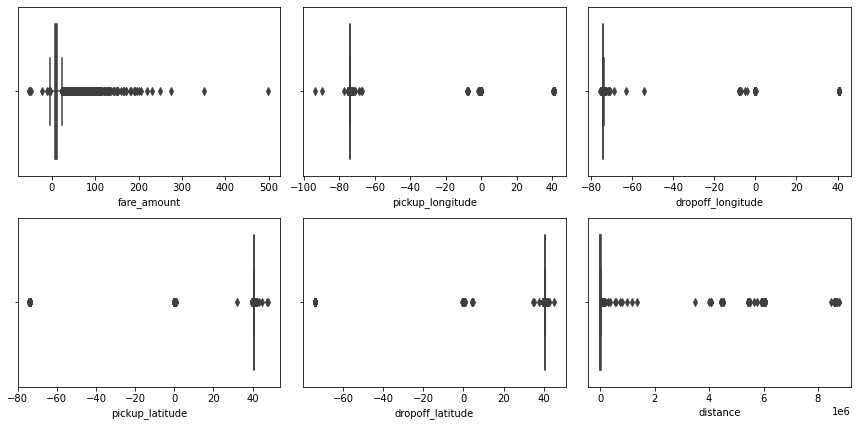

In [27]:
#visualizing outliers in numerical features

cnt = 1
plt.figure(figsize = (12,6))

for nf in num_features:
    plt.subplot(2,3,cnt)
    sns.boxplot(df[nf])
    plt.tight_layout(pad=1)
    cnt+=1
    
plt.show()

In [28]:
#Using  iqr method to select valid data

for i in num_features:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    
    iqr = q3 - q1
    lower = (q1 - 1.5*iqr)
    upper = (q3 + 1.5*iqr)
    
    df = df[(df[i] >= lower) & (df[i] <= upper)]
    df = df.reset_index(drop=True)
    
df.shape

(160141, 27)

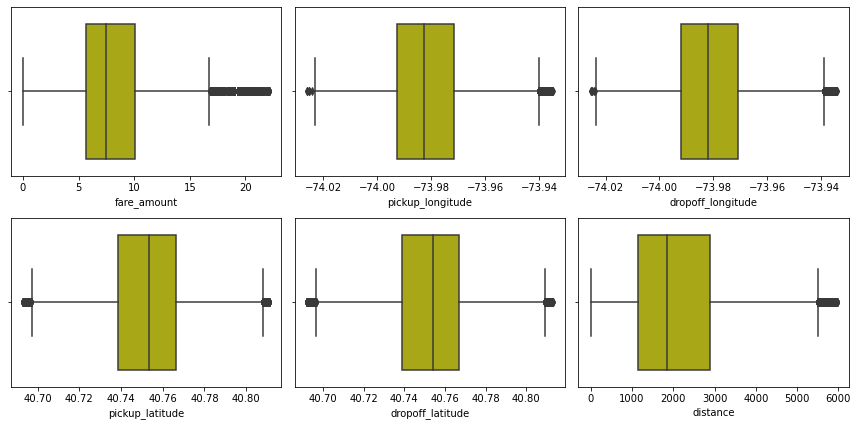

In [42]:
cnt = 1

plt.figure(figsize = (12,6))

for nf in num_features:
    plt.subplot(2,3,cnt)
    sns.boxplot(df[nf],color = 'y')
    plt.tight_layout(pad=1)
    cnt+=1
    
plt.show()

In [30]:
fm = df[df['fare_amount'] > 0].fare_amount.median()
df.loc[df['fare_amount'] < 0, 'fare_amount'] = fm

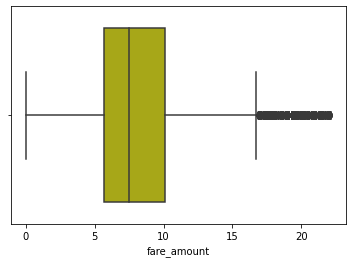

In [41]:
plt.figure()
sns.boxplot(df['fare_amount'],color= 'y')
plt.show()

In [35]:
df.shape

(160141, 27)

## Visualization

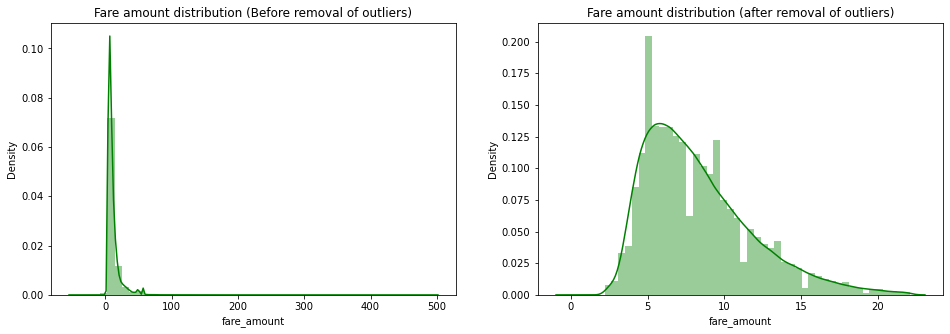

In [32]:
import seaborn as sns
plt.figure(figsize = [16,5])
plt.subplot(121)
sns.distplot(original_df['fare_amount'], color = 'g')
plt.title("Fare amount distribution (Before removal of outliers)")

plt.subplot(122)
sns.distplot(df['fare_amount'],color = 'g')
plt.title("Fare amount distribution (after removal of outliers)")
plt.show()

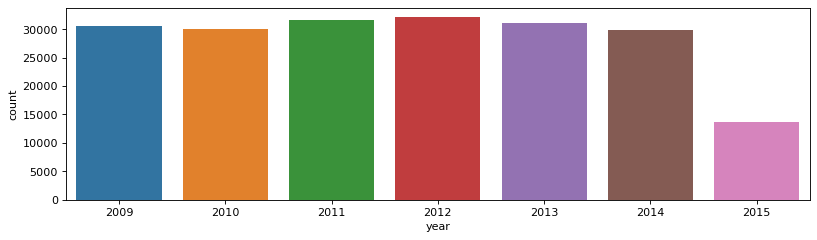

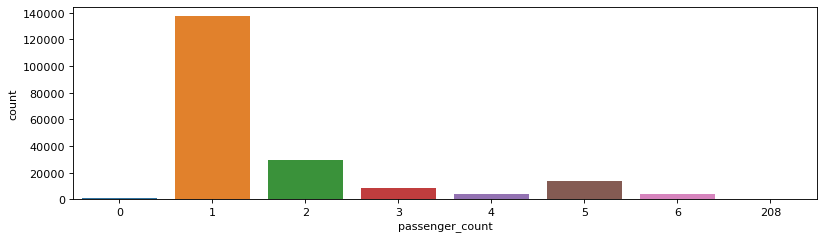

In [33]:
plt.figure(figsize = (12,7),dpi = 80)
plt.subplot(211)
sns.countplot(original_df.year)


plt.figure(figsize = (12,7),dpi = 80)
plt.subplot(212)
sns.countplot(original_df.passenger_count)

plt.show()

Preprocssing is done.

## Correlation

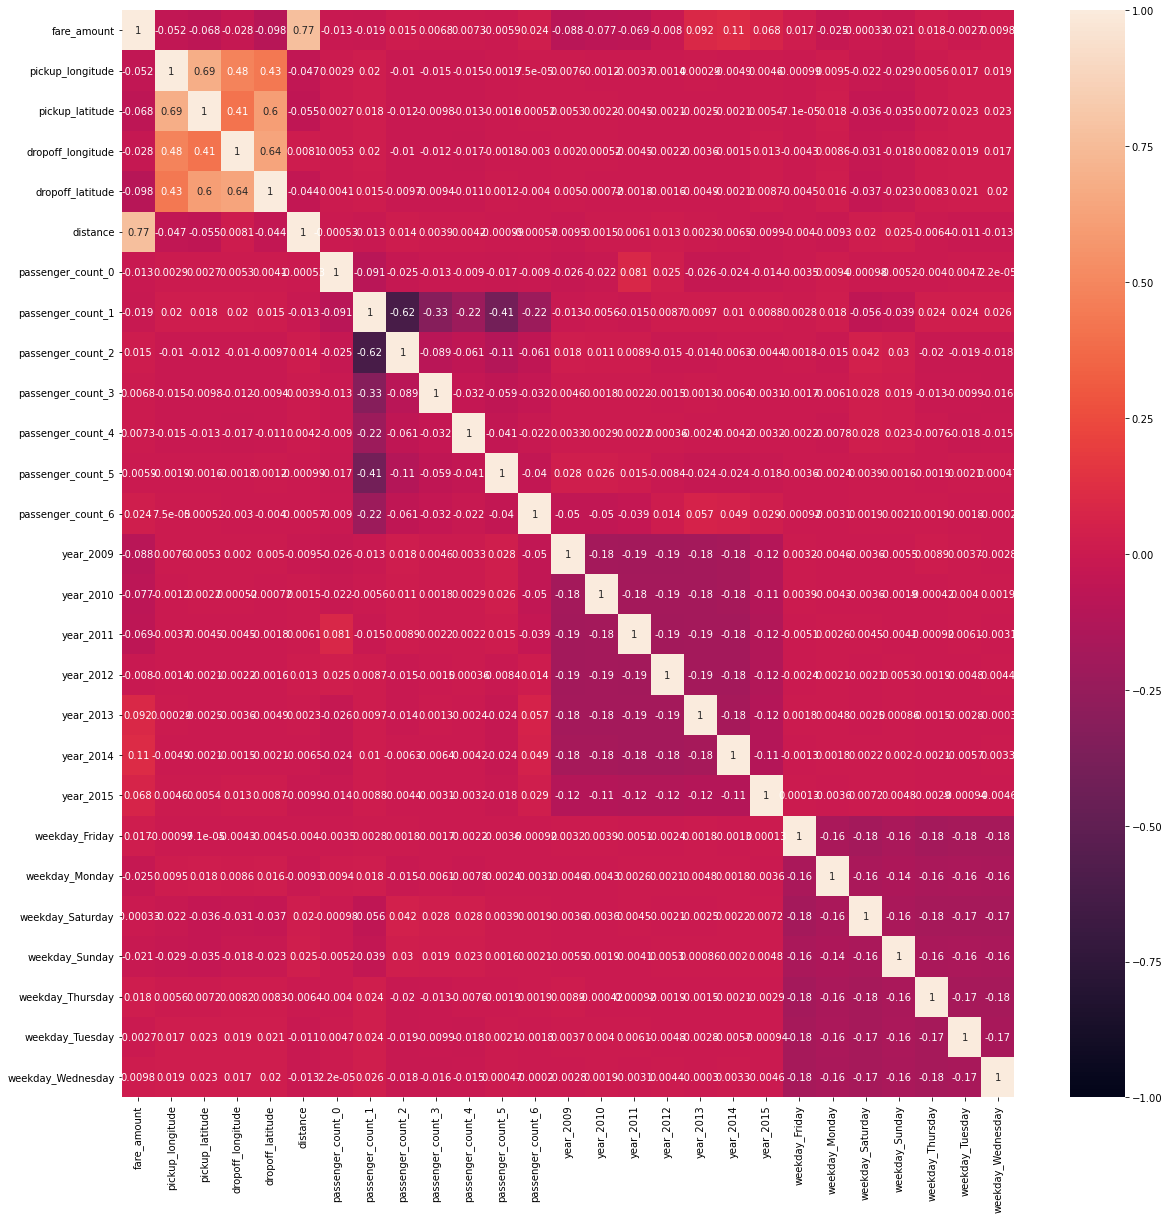

In [34]:
plt.figure(figsize = [20,20])
sns.heatmap(df.corr(),annot = True,vmin = -1,vmax = 1)
plt.show()

# Spliting and model building

### Normalization

In [88]:
y = df['fare_amount']
X = df.drop('fare_amount',axis = 1)

In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

Splitting

In [96]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_normalized,y,test_size = 0.2,random_state = 42,shuffle=True)

In [97]:
print((X_train.shape,y_train.shape))
print((X_test.shape,y_test.shape))

((128112, 26), (128112,))
((32029, 26), (32029,))


### Model Building 

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor

LR = LinearRegression()
RFR = RandomForestRegressor(max_depth=2)

In [ ]:
model1 = LR.fit(X_train,y_train)
model2 = RFR.fit(X_train,y_train)

In [143]:
y_test_pred_lr  = model1.predict(X_test)
y_test_pred_rfr = model2.predict(X_test)

y_train_pred_lr  = model1.predict(X_train)
y_train_pred_rfr = model2.predict(X_train)

### Evaluation

In [145]:
#test 

R2_LR_test = round(r2_score(y_test,y_test_pred_lr),4)
R2_RFR_test = round(r2_score(y_test,y_test_pred_rfr),4)

RMSE_LR_test  = round(mean_squared_error(y_test, y_test_pred_lr,squared = False),4)
RMSE_RFR_test = round(mean_squared_error(y_test, y_test_pred_rfr,squared=  False),4)


RSS_LR_test = round( (np.sum(np.square(y_test - y_test_pred_lr))), 4)
RSS_RFR_test = round( (np.sum(np.square(y_test - y_test_pred_rfr))), 4)


#train

R2_LR_train = round(r2_score(y_train,y_train_pred_lr),4)
R2_RFR_train = round(r2_score(y_train,y_train_pred_rfr),4)

RMSE_LR_train  = round(mean_squared_error(y_train, y_train_pred_lr,squared = False),4)
RMSE_RFR_train = round(mean_squared_error(y_train, y_train_pred_rfr,squared=  False),4)


RSS_LR_train = round( (np.sum(np.square(y_train - y_train_pred_lr))), 4)
RSS_RFR_train = round( (np.sum(np.square(y_train - y_train_pred_rfr))), 4)

In [146]:
test_summary = pd.DataFrame({
    "Metric":["R2 score","RMSE","RSS"],
    "Linear Regression":[R2_LR_test, RMSE_LR_test, RSS_LR_test],
    "Random Forest Regression":[R2_RFR_test, RMSE_RFR_test, RSS_RFR_test]
})

In [147]:
test_summary

,Metric,Linear Regression,Random Forest Regression
0,R2 score,0.6407,0.5653
1,RMSE,2.1012,2.3112
2,RSS,141407.4333,171084.7237


In [149]:
train_summary = pd.DataFrame({
    "Metric":["R2 score","RMSE","RSS"],
    "Linear Regression":[R2_LR_train, RMSE_LR_train, RSS_LR_train],
    "Random Forest Regression":[R2_RFR_train, RMSE_RFR_train, RSS_RFR_train]
})

In [150]:
train_summary

,Metric,Linear Regression,Random Forest Regression
0,R2 score,0.6357,0.5630
1,RMSE,2.1139,2.3153
2,RSS,572492.2407,686745.4052
